### Figure 3: Gene expression in patients vs. culture in sterile urine

Generates:
* **A** Volcano plot, with 4 functional categories marked up
* **B** Heatmap of the most important functional categories
* Supplemental graphs comparing B1 and B2 gene expression

In [1]:
import itertools
import matplotlib
from operator import itemgetter
import sys
sys.path.append('../methods')
from settings import *
import helpers
import keggAPI
%matplotlib inline
config_dict = helpers.process_config("config")

# Output
figures_dir = config_dict["out_dir"]["figures"]
results_dir = config_dict["out_dir"]["results"]
sup_dir = config_dict["out_dir"]["sup"]

# Data
de_genes_file = config_dict["data"]["media_de_file"]
de_analysis_all_genes_file = config_dict["data"]["all_genes_file"]
up_file = config_dict["data"]["up_file"]
down_file = config_dict["data"]["down_file"]
go_file = config_dict["data"]["go_file"]
pg_urine_file = config_dict["data"]["pg_urine_file"]
pg_uti_file = config_dict["data"]["pg_uti_file"]
counts = config_dict["data"]["deseq2_norm_counts_file"]

/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods/helpers.py


In [22]:
### DO NOT NEED to run this: was run once, to add KEGG annotations to all genes 
# Getting gene info on ALL core genes, not just differentially expressed ones
filename = os.path.join(results_dir, "media_all_genes_edited.csv")
de_all_edited = keggAPI.add_gene_info_to_file(de_analysis_all_genes_file, filename=filename)

In [10]:
### DO NOT NEED to run this: was run once to format DE tables
# Formating final DE tables
de_edited = keggAPI.add_gene_info_to_file(de_genes_file)
de_up = de_edited[de_edited.log2FoldChange > 2] # in Patients
de_up = de_up[["log2FoldChange", "padj", "Name", "Function", "Pathways"]].sort_index()
de_down = de_edited[de_edited.log2FoldChange < -2]
de_down = de_down[["log2FoldChange", "padj", "Name", "Function", "Pathways"]].sort_index()
#de_up.to_csv(os.path.join(results_dir, "UPREGULATED_IN_PATIENTS.csv"))
#de_down.to_csv(os.path.join(results_dir, "DOWNREGULATED_IN_PATIENTS.csv"))

In [2]:
de_edited = pd.concat([pd.read_csv(f, index_col=0) for f in [up_file, down_file]])
de_edited.head()

,log2FoldChange,padj,Name,Function,Pathways
Entry,,,,,
b0010,2.612565,5.731661e-10,satP,succinate-acetate transporter,NaN
b0013,2.668866,8.355803e-15,yaaI,UPF0412 family protein,NaN
b0023,2.176472,1.535949e-28,rpsT,30S ribosomal subunit protein S20,eco03010 Ribosome
b0058,2.428475,2.636524e-20,rluA,"dual specificity 23S rRNA pseudouridine(746), ...",NaN
b0059,2.832296,1.474793e-53,rapA,RNA polymerase remodeling/recycling factor ATP...,NaN


In [3]:
# GO analysis table:
go_analysis = (pd.read_csv(go_file, index_col=0)
              .sort_values("Annotated", ascending=False)
              .set_index("GO.ID"))
# Only look at GO grous with > 10 terms and p-value < 0.05
go_analysis = go_analysis[(go_analysis.Annotated >=10) & (go_analysis.elimFisher < 0.05)]
go_analysis.head()

,Annotated,Significant,Expected,elimFisher,Term,genesInTerm,DEGenesInTerm
GO.ID,,,,,,,
GO:0006518,89,24,16.63,0.03134,peptide metabolic process,"accD,acnB,adk,alaS,arfB,asnS,aspS,csrA,cysS,de...","deaD,gstA,pepT,raiA,rimP,rmf,rplA,rplD,rplY,rp..."
GO:0016052,76,36,14.20,0.00403,carbohydrate catabolic process,"agp,aldA,araA,araB,araD,cra,dctR,deoC,dgoD,dgo...","agp,aldA,araA,araB,araD,dctR,dgoD,dgoK,ebgA,fr..."
GO:0044262,75,29,14.01,0.00220,cellular carbohydrate metabolic process,"aceA,aceB,aceK,acnB,araB,arnT,csrA,dctR,dgoD,d...","aceA,aceB,araB,arnT,dctR,dgoD,dgoK,ebgA,fruK,f..."
GO:0015980,70,20,13.08,0.02632,energy derivation by oxidation of organic comp...,"aceK,acnB,csrA,cydB,cyoA,cyoB,cyoC,cyoD,dld,dm...","frdA,frdB,frdC,gldA,glgA,glgB,glgC,glgX,glpA,g..."
GO:0043043,69,19,12.89,0.04306,peptide biosynthetic process,"accD,acnB,adk,alaS,arfB,asnS,aspS,csrA,cysS,de...","deaD,raiA,rimP,rmf,rplA,rplD,rplY,rpsA,rpsB,rp..."


In [81]:
### DO NOT NEED to run this: was run once to generate GO analysis table
go_analysis_pretty = (go_analysis[["Annotated", "Significant", "Expected", "elimFisher", "Term"]]
                     .rename(columns={ "elimFisher": "P value"}))
go_analysis_pretty.index.name = "GO ID"
filename = os.path.join(results_dir, "GO_analysis_table.csv")
go_analysis_pretty.to_csv(filename)

In [4]:
def get_subset_genes(df, key, col_return,column_name="Function"):
    keep = []
    if not type(key) == str:
        return df[df[column_name].isin(key)][col_return]
    for i, x in zip(df.index, df[column_name]):
        if not type(x) == str:
            continue
        if key in x:
            keep.append(i)
    return df.loc[keep][col_return]

In [5]:
def get_go(go_analysis_df, GO_ID): # list of GO.ID numbers
    genes = []
    for go in GO_ID:
        genes += go_analysis_df.loc[go]["DEGenesInTerm"].split(',')
    return set(genes)


In [6]:
# UP
col_return = ["log2FoldChange", "Name", "Function"]
rprotein = get_subset_genes(de_edited, "ribosomal subunit protein", col_return)
rRNA = get_subset_genes(de_edited, "rRNA", col_return)
rna_helicase = get_subset_genes(de_edited, "helicase",col_return)
tRNA_genes = get_go(go_analysis, ["GO:0006400", "GO:0008033"])
tRNA =get_subset_genes(de_edited, tRNA_genes, col_return, "Name")
purine = get_subset_genes(de_edited[de_edited.log2FoldChange >0], "urine", col_return + ["Pathways"] , "Pathways")
pyrimidine = get_subset_genes(de_edited[de_edited.log2FoldChange >0], "yrimidine", col_return, "Pathways")
flagella_genes = "flgB,flgC,flgD,flgE,flgG".split(',')
flagella = get_subset_genes(de_edited, flagella_genes, col_return, "Name")
aa_t = ["b1605", "b2678", "b2679", "b2796", "b2845",
        "b3184", "b3539", "b3795", "b3827", "b4156"]
aa_trans = de_edited.loc[aa_t][col_return]

In [7]:
up_subsets={"Ribosomal Proteins":rprotein,
             "rRNA Modification":rRNA,
            "RNA Helicases": rna_helicase,
           "tRNA Processing/Modification": tRNA,
           "Purine Metabolism":purine,
           "Pyrimidine Metabolism":pyrimidine,
            "Amino Acid Transporters": aa_trans,
            "Flagella": flagella }

In [8]:
# Get DESeq2 normalized counts
cnts = pd.read_csv(counts, index_col=0)
cnts = cnts.reindex(sorted(cnts.columns, key=lambda x: x.split("_")[1]), axis=1)
cnts.index.name = "Entry"
cnts.columns = [sample_label_from_sample_name(c) for c in cnts.columns]
cnts.head()

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Entry,,,,,,,,,,,,,,,,,,,,,
b4182,43.611405,48.441622,68.101452,64.194761,11.495513,172.758571,26.750200,37.612372,60.756947,63.395462,...,2.816262,118.443069,43.165756,24.688754,19.894555,166.980574,31.895288,170.473444,16.800147,24.255873
b1960,52.567318,84.708076,76.162440,109.587708,93.828239,95.855494,47.886161,57.569957,49.024571,49.005081,...,118.987051,159.640658,67.691753,119.916804,98.869907,182.883486,85.054101,170.473444,168.001469,100.853368
b2866,1095.347156,237.027186,595.401268,317.213440,236.124046,637.821729,228.862825,988.668054,1257.459289,588.060974,...,13.377242,46.347288,96.141910,50.553163,36.171917,206.737854,53.158813,340.946889,26.880235,25.532498
b0328,226.623549,216.303498,58.372673,282.027191,222.764396,190.982049,60.435638,215.311638,173.471558,160.238837,...,22.530093,5.149699,131.459346,14.107859,10.851575,95.417471,223.267015,340.946889,16.800147,7.659749
b1660,413.140182,763.408872,829.169926,780.006630,773.616939,477.819592,270.804498,697.747874,317.193163,194.464608,...,775.175995,257.484932,233.487496,2075.030976,859.685903,834.902872,1339.602089,340.946889,1018.088904,439.158969


In [9]:
print("URINE")
print(cnts.loc["b3985"][0:14].mean()/cnts.loc["b0344"][:14].mean()) # 1.38868
print("UTI")
print(cnts.loc["b3985"][14:].mean()/cnts.loc["b0344"][14:].mean()) # 955.30532

URINE
1.3886828518612677
UTI
955.3053238648884


In [10]:
cnts_up = pd.concat(up_subsets.values(), axis=0, keys=up_subsets.keys(), names = ["Function", "Entry"],sort=False)
cnts_up = cnts_up.join(cnts, how='inner')
cnts_up.head()
up_summary = cnts_up.groupby(level=(0), sort=False).agg(['mean'])
up_summary_no_LFC = up_summary.iloc[:, 1:]
up_summary_no_LFC.columns = up_summary_no_LFC.columns.droplevel(level=1)

In [11]:
cnts_up.loc["Ribosomal Proteins"].sort_values('log2FoldChange')

,log2FoldChange,Name,Function,Pathways,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Entry,,,,,,,,,,,,,,,,,,,,,
b3308,2.070644,rplE,50S ribosomal subunit protein L5,NaN,4657.464390,4227.373392,7660.162526,4003.174522,5923.917343,9969.335852,...,39777.582386,33612.082991,28876.909407,29795.798899,43210.972482,26001.260880,28546.282618,12359.324717,22885.160150,30211.328467
b3301,2.077285,rplO,50S ribosomal subunit protein L15,NaN,3241.261900,2066.410782,2975.060582,1521.066648,2181.351218,5535.563664,...,34663.251387,24816.397722,24794.802390,18929.220253,30485.691953,24832.396859,19211.595043,9290.802718,15936.619379,20388.976419
b3294,2.081044,rplQ,50S ribosomal subunit protein L17,NaN,843.802804,411.106169,701.305975,286.861942,368.167098,1147.350172,...,3007.767350,5376.285375,3075.560081,3130.769116,5194.287333,3617.912447,2817.417093,1960.444610,4683.880964,3726.468109
b3310,2.090842,rplN,50S ribosomal subunit protein L14,NaN,4070.267977,4691.843058,9864.147890,6043.976993,6890.783173,10468.659148,...,50779.308184,36387.770555,28552.185201,33042.957855,47829.523464,29746.396622,34733.968460,21053.470380,28482.969107,36948.078111
b3636,2.092727,rpmG,50S ribosomal subunit protein L33,NaN,230.128037,134.703975,141.484241,33.306068,62.759286,77.632016,...,378.787180,571.616548,243.297895,209.266580,343.633215,691.776666,318.952878,340.946889,551.044819,262.984731
b3984,2.105356,rplA,50S ribosomal subunit protein L1,NaN,4457.319193,3126.945536,9885.551204,2601.365086,3467.916578,6050.923621,...,17403.088331,28107.055150,40416.881731,23091.038754,41364.396100,19966.105832,9409.109913,11762.667662,20976.663458,24640.137365
b3306,2.107520,rpsH,30S ribosomal subunit protein S8,NaN,4270.023786,3325.374853,6931.338005,3997.265381,5407.240649,11169.898579,...,48831.159247,34420.585677,29496.926623,28129.895844,42492.959922,24911.911418,29460.614203,13467.402105,24723.096224,30793.469426
b3259,2.109671,prmA,methyltransferase for 50S ribosomal subunit pr...,NaN,241.420276,237.027186,272.683774,189.629711,245.755421,448.662027,...,1125.800560,2255.568002,1275.351868,1725.861458,1892.997009,1383.553331,1243.916226,1108.077388,924.008081,1838.339869
b3637,2.155328,rpmB,50S ribosomal subunit protein L28,NaN,682.985749,1480.448491,2578.404369,1416.582289,1719.045191,2046.861044,...,10032.227754,7626.703679,7404.889153,6340.307113,10266.193013,6353.213285,7952.558435,2812.811832,7422.304914,10879.397473


In [12]:
labels = []
sizes = cnts_up.groupby(level=0, sort=False).size()
for i,size in enumerate(sizes):
    labels.append("{} (n={})".format(sizes.index[i], size))
labels
up_summary_no_LFC.index = labels
up_summary_no_LFC

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Ribosomal Proteins (n=38),3349.265707,3238.819369,5952.973964,3105.387966,3883.447477,6849.476425,6415.841757,6306.303942,7350.223239,4587.440570,...,38215.965350,34332.498726,27020.136499,25387.897255,39401.831610,25093.957909,24922.530266,15665.612309,25291.029612,29153.107204
rRNA Modification (n=6),252.777413,288.404664,444.512540,216.176080,185.429870,236.054784,179.270376,198.744283,131.919393,133.856472,...,970.554141,2034.130961,967.795860,1523.060980,1344.389595,1407.407699,1348.461892,937.603944,1714.174992,1557.056847
RNA Helicases (n=3),1034.732495,747.607060,1302.451855,791.198185,656.383422,952.601938,825.183136,817.109583,700.869789,632.398905,...,3128.631908,5841.474818,3992.178360,10499.382419,8645.691115,7052.941407,8161.649767,2755.987351,7492.865531,4201.798117
tRNA Processing/Modification (n=13),510.487068,600.668138,1052.418674,475.975120,451.694784,539.106550,375.163304,362.484065,297.563996,232.011236,...,3469.038498,5681.702117,2573.343118,3445.392466,5019.781019,3811.193991,3885.500321,2399.741563,5165.657486,4669.697513
Purine Metabolism (n=7),2114.986248,2002.907479,3630.025802,1935.128609,2232.703759,3558.003904,3192.615185,3577.835729,3513.846584,2239.509986,...,18232.779104,19789.556183,13781.648492,15049.894839,20459.611573,13301.649843,15362.896977,10021.403194,17269.111033,16603.601189
Pyrimidine Metabolism (n=5),2671.899436,2221.423971,3586.472640,2108.220399,2574.622030,4531.450029,3948.263526,4338.855726,4380.366348,2732.072169,...,20653.335801,23794.697513,15005.593869,18218.419273,24747.740702,15669.139049,18830.977942,11404.673429,20222.672864,19493.041058
Amino Acid Transporters (n=10),148.979674,179.570760,246.388274,170.344423,158.078835,183.729105,200.560453,130.108102,162.744814,154.288220,...,737.930936,1178.251048,974.466931,935.351073,2316.931880,1252.354308,1024.901916,758.606827,1183.402350,1404.670387
Flagella (n=5),20.559662,648.133355,20.902976,35.132530,14.850960,86.670861,385.467085,20.801944,29.582348,27.613974,...,4595.716432,332.670532,262.918693,13.167335,27.731803,50.889318,59.537871,204.568133,42.336370,116.938842


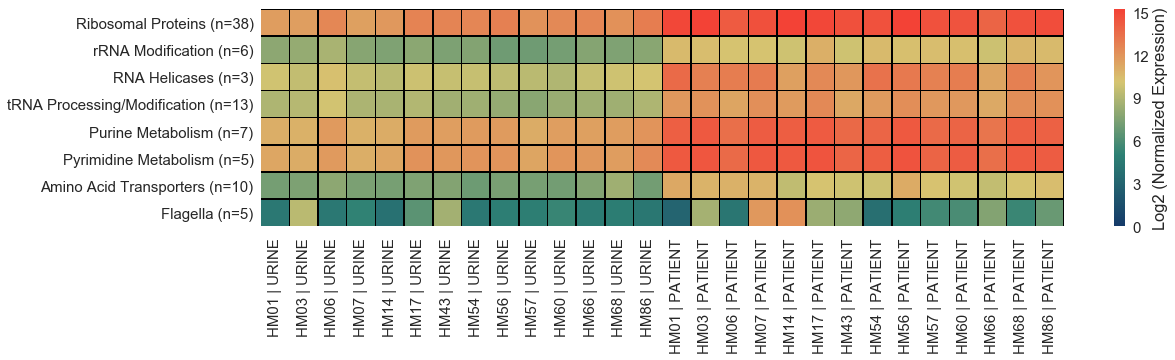

In [13]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(18,4))
sns.heatmap(np.log2(up_summary_no_LFC+1), cmap=my_cmap, linewidths=0.5, linecolor='black',
            vmin=0, cbar_kws={'label': 'Log2 (Normalized Expression)'})
ax = fig.gca()
fn = os.path.join(figures_dir, "Figure_3b_i.png")
fig.savefig(fn, dpi=100, bbox_inches="tight")

In [13]:
# DOWN
arginine = get_subset_genes(de_edited, "Arginine", col_return, "Pathways")
val = get_subset_genes(de_edited, "Valine", col_return, "Pathways")
maltose = get_subset_genes(de_edited, "maltose", col_return)
cys = get_subset_genes(de_edited, "Cysteine", col_return, "Pathways" )
glycine = get_subset_genes(de_edited, "Glycine", col_return, "Pathways" )
galactose = get_subset_genes(de_edited, "Galactose", col_return, "Pathways" )
starch =  get_subset_genes(de_edited, "Starch", col_return, "Pathways" )

In [14]:
carb_transport_genes = get_go(go_analysis, ['GO:0034219'])
carb_transport = get_subset_genes(de_edited, carb_transport_genes, col_return, "Name")
biofilm_genes = get_go(go_analysis, ['GO:0042710'])
biofilm = get_subset_genes(de_edited[de_edited.log2FoldChange<0], biofilm_genes, col_return, 'Name')
carb_transport_up = carb_transport[carb_transport.log2FoldChange > 0] # make a sepearte figure for this
carb_transport_down = carb_transport[carb_transport.log2FoldChange < 0]
biofilm

,log2FoldChange,Name,Function
Entry,,,
b0836,-4.792774,bssR,repressor of biofilm formation by indole trans...
b1037,-2.226212,csgG,curli production assembly/transport outer memb...
b1038,-3.280083,csgF,curli nucleation outer membrane protein
b1039,-3.502387,csgE,curlin secretion specificity factor
b1040,-3.978146,csgD,csgBAC operon transcriptional regulator
b1041,-2.450621,csgB,"curlin nucleator protein, minor subunit in cur..."
b1042,-3.164985,csgA,"curlin subunit, amyloid curli fibers, cryptic"
b1205,-3.672422,ychH,DUF2583 family putative inner membrane protein
b3049,-3.889036,glgS,motility and biofilm regulator


In [15]:
down_subsets = {"Arginine Metabolism":arginine,
               "Val/Leu/Ileu Metabolism":val,
               "Cys/Met Metabolism": cys,
               "Gly/Ser/Thr Metabolism": glycine,
               "Maltose Metabolism": maltose,
               "Galactose Metabolism": galactose,
               "Starch/Sucrose Metabolism": starch,
                "Sugar Transporters":carb_transport_down,
               "Biofilm/Curli": biofilm,}

In [16]:
cnts_down = pd.concat(down_subsets.values(), axis=0, keys=down_subsets.keys(), names = ["Function", "Entry"],sort=False)
cnts_down = cnts_down.join(cnts, how='inner')
cnts_down.head()
down_summary = cnts_down.groupby(level=(0), sort=False).agg(['mean'])
down_summary_no_LFC = down_summary.iloc[:, 1:]
down_summary_no_LFC.columns = down_summary_no_LFC.columns.droplevel(level=1)
labels = []
sizes = cnts_down.groupby(level=0, sort=False).size()
for i,size in enumerate(sizes):
    labels.append("{} (n={})".format(sizes.index[i], size))
labels
down_summary_no_LFC.index = labels
down_summary_no_LFC

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Arginine Metabolism (n=10),4200.011906,3610.325569,4656.082387,1898.016133,5833.910586,3476.019080,3093.941386,6488.556284,5948.901204,2530.295692,...,993.436266,673.065612,687.022241,349.522215,401.809715,291.023287,341.279580,443.230955,471.748126,857.125964
Val/Leu/Ileu Metabolism (n=15),1329.343109,4246.974547,5306.946959,3992.126219,987.619890,14644.095311,1855.583241,2054.275157,11662.931415,1315.773465,...,233.843585,352.926013,510.206150,270.870899,281.015607,221.050475,152.388597,386.406474,218.625912,442.903735
Cys/Met Metabolism (n=8),8609.991309,10385.611690,16605.010303,5528.068682,22737.075653,35242.201788,28647.029016,26208.866650,33523.535724,41633.705758,...,1914.881847,981.661302,1848.524428,835.155881,615.374744,518.832499,534.246071,926.949354,885.367743,1184.388759
Gly/Ser/Thr Metabolism (n=8),4318.015800,4642.332871,4666.721501,3618.912475,5631.830345,7124.514266,5650.236769,6712.369086,6507.435624,6509.362436,...,1227.185976,617.963836,986.312988,822.370633,669.331188,486.032744,463.810644,628.620826,643.445627,1027.683052
Maltose Metabolism (n=5),5324.173739,796.825820,3621.996581,473.107327,3696.273385,158.762940,899.004882,5103.691789,1726.921931,1876.972395,...,14.222121,38.107770,518.381482,29.861636,50.399538,98.598053,82.927748,221.615478,36.960323,46.724472
Galactose Metabolism (n=21),3539.606926,2537.701996,2052.653216,1673.821783,2415.196874,1844.684573,953.508612,2480.936157,2217.019986,1303.301802,...,76.575493,147.624694,218.258019,171.141770,147.788120,138.203877,120.999584,182.650119,98.240859,156.599322
Starch/Sucrose Metabolism (n=8),1428.711565,1453.410554,1278.396291,1622.865034,1364.820286,1644.987797,1422.012581,1433.443943,1736.810648,2077.076477,...,175.576307,122.305343,418.168257,163.122123,192.238669,178.907758,151.502617,351.601479,120.121051,223.728515
Sugar Transporters (n=16),4734.733480,2619.020886,2719.784373,2759.787146,3928.416721,1096.916697,919.145967,4050.790056,1658.219442,2324.702847,...,177.116450,146.122699,499.717198,121.533330,170.949989,226.616494,214.628708,351.601479,159.601396,244.393881
Biofilm/Curli (n=10),1457.243937,702.843893,503.644984,842.025752,871.359867,294.819426,733.814139,583.951259,683.033785,447.851992,...,15.911878,20.083825,140.975433,13.284901,27.249511,27.830096,24.453054,51.142033,35.616311,239.239508


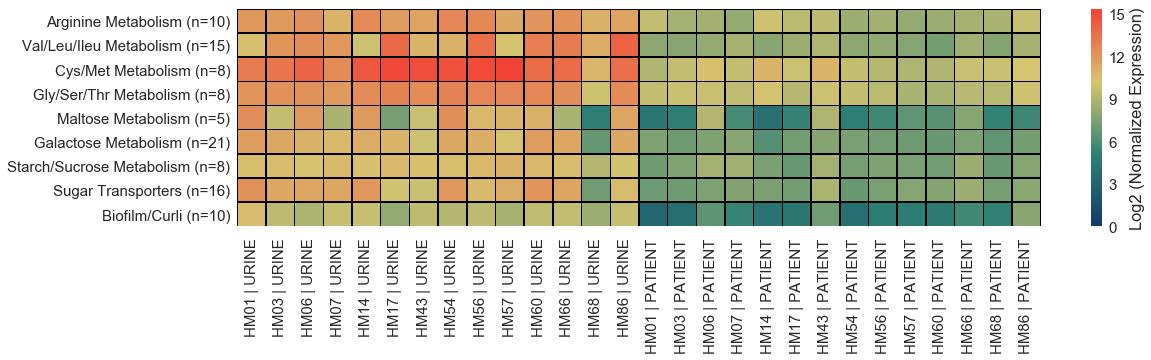

In [18]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(18,4))
sns.heatmap(np.log2(down_summary_no_LFC+1), cmap=my_cmap, linewidths=0.5, linecolor='black',
            vmin=0, cbar_kws={'label': 'Log2 (Normalized Expression)'})
ax = fig.gca()
fn = os.path.join(figures_dir, "Figure_3b_ii.png")
fig.savefig(fn, dpi=100, bbox_inches="tight")

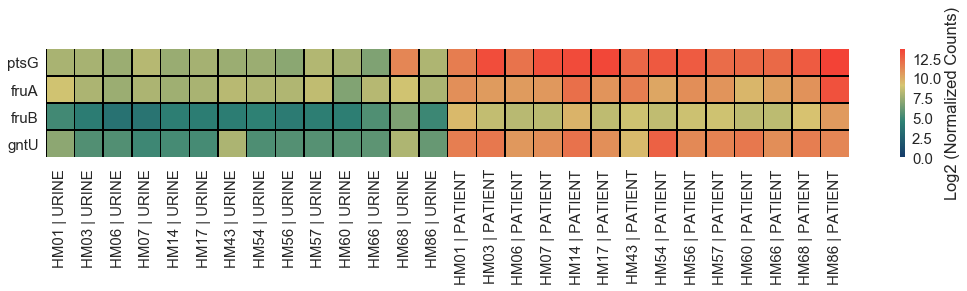

In [19]:
carbs_up = carb_transport_up.join(cnts, how="inner")
carbs_up_summary = carbs_up.groupby("Entry", sort=False).agg('mean').iloc[:,1:]
carbs_up_summary
labels = [carbs_up.loc[i]["Name"] for i in carbs_up.index]
carbs_up_summary.index = labels
fig = plt.figure(figsize=(18,2))
sns.heatmap(np.log2(carbs_up_summary+1), cmap=my_cmap, linewidths=0.5, linecolor='black',
            vmin=0, cbar_kws={'label': 'Log2 (Normalized Counts)'})
fn = os.path.join(sup_dir, "Figure_S6.png")
fig.savefig(fn, dpi=100, bbox_inches="tight")

In [17]:
# Drawing the volcano plot

translation_replication_genes = [d.index for d in [rprotein, rRNA, rna_helicase, tRNA, purine, pyrimidine]]
translation_replication_genes = set([g for r in translation_replication_genes for g in r])
aa_tt_genes = aa_trans.index
sugar_aa_metabolism_genes = [d.index for d in [arginine, val, cys, glycine, maltose, galactose, starch]]
sugar_aa_metabolism_genes = set([g for r in sugar_aa_metabolism_genes for g in r])
sugar_tt_genes = carb_transport_down.index

In [19]:
vplf = pd.read_csv(de_analysis_all_genes_file, index_col=0 )
vplf_up = vplf[(vplf.log2FoldChange >= 2)& (vplf.padj < 0.01)]
vplf_down = vplf[(vplf.log2FoldChange <= -2)& (vplf.padj < 0.01)]
print("Down: ", vplf_down.shape[0]) # 343
print("Up: ", vplf_up.shape[0]) # 149


Down:  343
Up:  149


In [20]:
trans_rep_df = vplf.loc[translation_replication_genes ] 
aa_transp_df = vplf.loc[aa_tt_genes]
sugar_aa_met_df = vplf.loc[sugar_aa_metabolism_genes]
sugar_tt_df = vplf.loc[sugar_tt_genes]

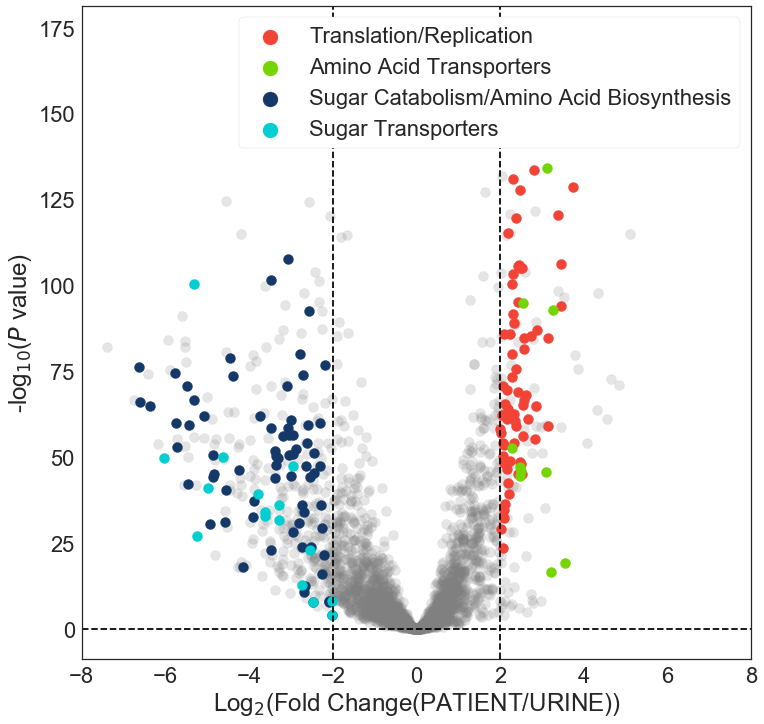

In [21]:
sns.set_context("notebook", font_scale=2.2)
fig = plt.figure(figsize=(12,12))
#plt.yscale('log')
plt.xlim(-8, 8)
plt.rcParams["lines.markersize"] = 10.0
plt.scatter(vplf.log2FoldChange, np.log(vplf.padj)*(-1), color='grey', alpha=0.2, label=None)
plt.scatter(trans_rep_df.log2FoldChange, np.log(trans_rep_df.padj)*(-1), color=col1, label="Translation/Replication")
plt.scatter(aa_transp_df.log2FoldChange, np.log(aa_transp_df.padj)*(-1), color="#74d600",  label="Amino Acid Transporters")
plt.scatter(sugar_aa_met_df.log2FoldChange, np.log(sugar_aa_met_df.padj)*(-1), color=col5, 
            label="Sugar Catabolism/Amino Acid Biosynthesis")
plt.scatter(sugar_tt_df.log2FoldChange, np.log(sugar_tt_df.padj)*(-1), color="#00ced1",  label="Sugar Transporters")

plt.axvline(-2, color='k', linestyle="--",)
plt.axvline(2, color='k', linestyle="--")
plt.axhline(0.01, color='k', linestyle="--")
plt.xlabel("Log$_2$(Fold Change(PATIENT/URINE))")
plt.ylabel("-log$_1$$_0$($\itP$ value)")
#plt.gca().invert_yaxis()

plt.legend(markerscale=1.5, frameon=True, facecolor="white", framealpha=1)
fn = os.path.join(figures_dir, "Figure_3a.png")
fig.savefig(fn, dpi=150, bbox_inches="tight")

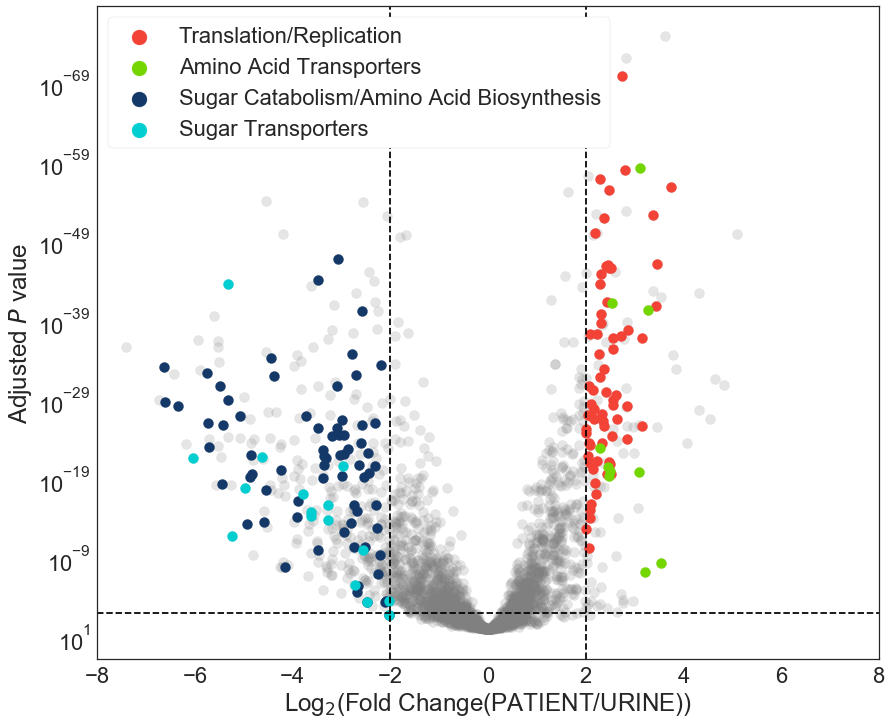

In [22]:
sns.set_context("notebook", font_scale=2.2)
fig = plt.figure(figsize=(14,12))
plt.yscale('log')
plt.xlim(-8, 8)
plt.rcParams["lines.markersize"] = 10.0
plt.scatter(vplf.log2FoldChange, vplf.padj, color='grey', alpha=0.2, label=None)
plt.scatter(trans_rep_df.log2FoldChange, trans_rep_df.padj, color=col1, label="Translation/Replication")
plt.scatter(aa_transp_df.log2FoldChange, aa_transp_df.padj, color="#74d600",  label="Amino Acid Transporters")
plt.scatter(sugar_aa_met_df.log2FoldChange, sugar_aa_met_df.padj, color=col5, 
            label="Sugar Catabolism/Amino Acid Biosynthesis")
plt.scatter(sugar_tt_df.log2FoldChange, sugar_tt_df.padj, color="#00ced1",  label="Sugar Transporters")

plt.axvline(-2, color='k', linestyle="--",)
plt.axvline(2, color='k', linestyle="--")
plt.axhline(0.01, color='k', linestyle="--")
plt.xlabel("Log$_2$(Fold Change(PATIENT/URINE))")
plt.ylabel("Adjusted $\itP$ value")
plt.gca().invert_yaxis()

plt.legend(markerscale=1.5, frameon=True, facecolor="white", framealpha=1)
fn = os.path.join(figures_dir, "Figure_3a.png")
fig.savefig(fn, dpi=150, bbox_inches="tight")

In [23]:
vplf.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Name,Function,Pathways
Entry,,,,,,,,,
b4476,1488.531825,5.100177,0.333345,15.299976,7.648475e-53,1.014570e-50,gntU,"gluconate transporter, low affinity GNT 1 system",NaN
b3437,1474.527474,4.826310,0.403515,11.960673,5.709728e-33,1.294693e-31,gntK,gluconate kinase 2,"eco00030 Pentose phosphate pathway, eco01100 ..."
b1821,202.147835,4.647350,0.383798,12.108841,9.482438e-34,2.246152e-32,mntP,"putative Mn(2+) efflux pump, mntR-regulated",NaN
b0990,1787.553949,4.546583,0.410317,11.080666,1.557104e-28,2.401743e-27,cspG,"cold shock protein homolog, cold-inducible",NaN
b2169,291.824752,4.322020,0.306947,14.080653,4.994597e-45,3.081550e-43,fruB,fused fructose-specific PTS enzymes: IIA compo...,"eco00051 Fructose and mannose metabolism, eco..."


In [27]:
transporters = get_subset_genes(de_edited, "transporter", col_return)
transporters_df = vplf.loc[transporters.index]
transporters_df.shape

(55, 9)

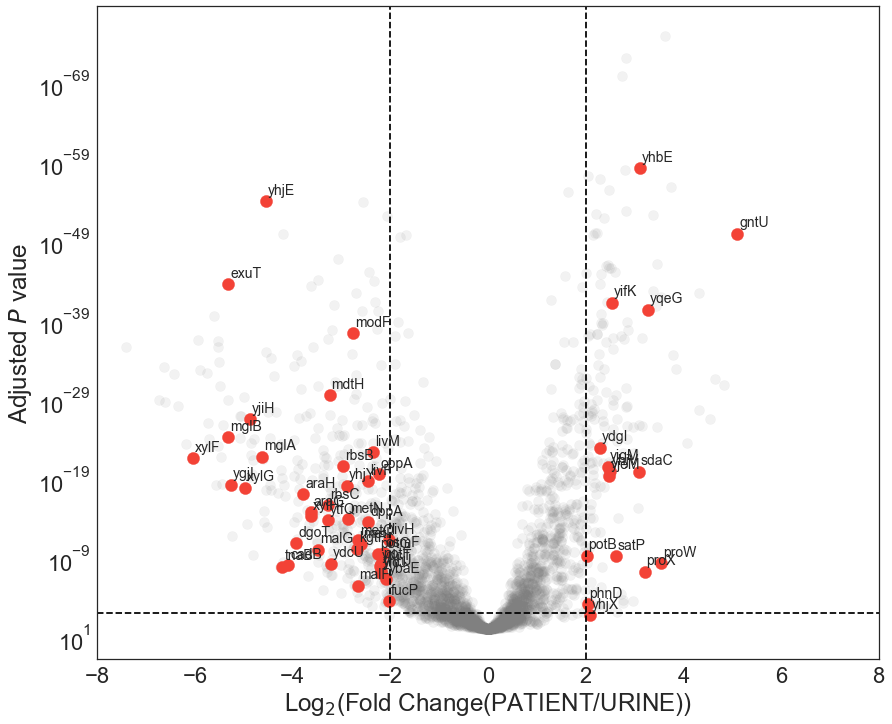

In [40]:
# For Ally
sns.set_context("notebook", font_scale=2.2)
fig = plt.figure(figsize=(14,12))
plt.yscale('log')
plt.xlim(-8, 8)
plt.rcParams["lines.markersize"] = 10.0
plt.scatter(vplf.log2FoldChange, vplf.padj, color='grey', alpha=0.1, label=None)

x, y = transporters_df[["log2FoldChange"]].values, transporters_df[["padj"]].values
ax = plt.scatter(x, y, c=col1, s=150)  
labels = transporters_df["Name"]
for label, px, py in zip(labels, x, y):
    plt.annotate(label, xy=(px, py), xytext=(2, 7), textcoords="offset points", fontsize=14)
plt.axvline(-2, color='k', linestyle="--",)
plt.axvline(2, color='k', linestyle="--")
plt.axhline(0.01, color='k', linestyle="--")
plt.xlabel("Log$_2$(Fold Change(PATIENT/URINE))")
plt.ylabel("Adjusted $\itP$ value")
plt.gca().invert_yaxis()
fn = "/Users/annasintsova/Desktop/Allyson/volcano_all_transporters.png"
fig.savefig(fn, dpi=150, bbox_inches="tight")

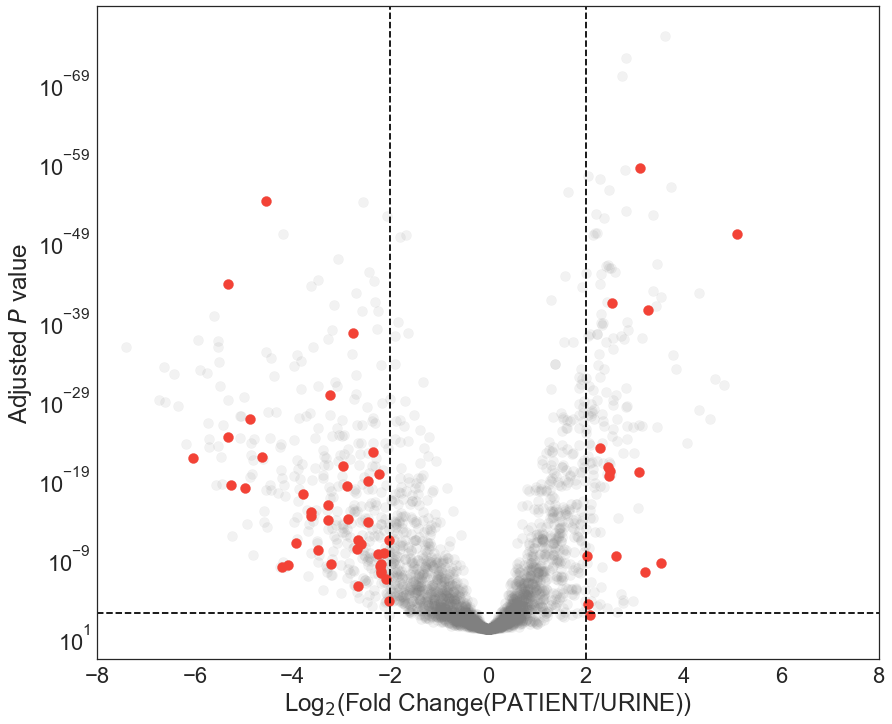

In [42]:
sns.set_context("notebook", font_scale=2.2)
fig = plt.figure(figsize=(14,12))
plt.yscale('log')
plt.xlim(-8, 8)
plt.rcParams["lines.markersize"] = 10.0
plt.scatter(vplf.log2FoldChange, vplf.padj, color='grey', alpha=0.1, label=None)

plt.scatter(transporters_df[["log2FoldChange"]], transporters_df[["padj"]], color=col1)

plt.axvline(-2, color='k', linestyle="--",)
plt.axvline(2, color='k', linestyle="--")
plt.axhline(0.01, color='k', linestyle="--")
plt.xlabel("Log$_2$(Fold Change(PATIENT/URINE))")
plt.ylabel("Adjusted $\itP$ value")
plt.gca().invert_yaxis()
fn = "/Users/annasintsova/Desktop/Allyson/volcano_all_transporters_no_labels.png"
fig.savefig(fn, dpi=150, bbox_inches="tight")

### Gene expression in B1 vs. B2 phylogroup 
#### Urine

In [25]:
### DO NOT NEED to run this
de_urine = keggAPI.add_gene_info_to_file(pg_urine_file)
de_urine = de_urine[["log2FoldChange", "padj", "Name", "Function", "Pathways"]].sort_index()
fn = os.path.join(results_dir, "DE_IN_URINE.csv")
de_urine.to_csv(fn)

#### Patients

In [62]:
### DO NOT NEED to run this
de_uti = keggAPI.add_gene_info_to_file(pg_uti_file)
de_uti = de_uti[["log2FoldChange", "padj", "Name", "Function", "Pathways"]].sort_index()
fn = os.path.join(results_dir, "DE_IN_PATIENTS.csv")
de_uti.to_csv(fn)